# import and load 

In [7]:
#%%
import networkx as nx
import igraph as ig
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import uunet.multinet as ml
import json

folder = '/Users/alessiogandelli/data/cop26/'
cop = 26

full_network_path = folder + '/networks/cop26_retweets.gml'
topics_file = folder + 'cache/topics_cop26.csv'
projected_path = folder + 'networks/cop26_retweets_ml.gml'

test_network = '/Users/alessiogandelli/dev/internship/tweets-to-topic-network/data/networks/toy_test.gml'

# load network
g = ig.read(full_network_path, format='gml')

mln = ml.read(projected_path)
topic_name = pd.read_csv(topics_file)
topic_label = json.load(open(folder + '/cache/labels.json'))

/Users/alessiogandelli/dev/tweets-to-topic-network/.venv/lib/python3.9/site-packages/igraph/io/files.py:295: RuntimeWarning: One or more unknown entities will be returned verbatim (&#127793;). at src/io/gml.c:149
  return reader(f, *args, **kwds)


In [101]:
topic_label = json.load(open(folder + '/cache/labels.json'))

# data preparation

In [62]:
# %%
# subset of nodes : users, tweets, original tweets
tweets = g.vs.select(bipartite=1)
user = g.vs.select(bipartite=0)
original_tweets = g.vs.select(is_retweet='original')

#create dataframe of tweets 
df_tweets = pd.DataFrame({'tweets': tweets['label'], 
                          'author': tweets['author'], 
                          'topic': tweets['topics']}
                          )

 
# create dataframe with original tweets 
original_tweets_indegree = g.degree(original_tweets, mode='in')
df_original = pd.DataFrame({'tweets': original_tweets['label'], 
                                            'indegree': original_tweets_indegree, 
                                            'author': original_tweets['author'],
                                            'topic': original_tweets['topics']})

df_original['indegree'] = df_original['indegree'] - 1 # do not count the edge from the author, only retweets 
df_rt_user = df_original.rename(columns={'indegree': 'retweets'})
# dataframe with users that creates original tweets
df_rt_user = df_rt_user.groupby('author').aggregate({'tweets':'count', 'retweets':'sum'})
df_rt_user['rt_per_tweet'] = round(df_rt_user['retweets'] / df_rt_user['tweets'])

original_user_no_rt = df_rt_user[df_rt_user['retweets'] > 0] # oringal users with 0 retweets 

top_users = {}
for i in [100000,115921, 10000,1000,100,10,3]:

    top_users[i] =  df_rt_user.sort_values('retweets', ascending=False).head(i).sum()
    
df_top_users = pd.DataFrame.from_dict(top_users, orient='index')[['tweets', 'retweets']]


In [10]:
#count how many topics a user tweets about
df_tweets.groupby('author').aggregate({'tweets':'count', 'topic':'nunique'}).sort_values('topic', ascending=False).head(100)




,tweets,topic
author,,
jobnoble_7,3206,63
Eco1stArt,4435,63
CorradoTopi,1441,59
jane__eden,1888,57
IndiaSciPol,2604,57
...,...,...
LOVE2UNIQUE,231,31
weincludedorg,227,31
VinKyenkyehene,202,31


# stats 

## basic 

Out of 454k tweets, most of them are copies (retweets). we call the tweets that are not retweeted but wrote by someone original tweets.

original tweets are 110k (24%) and retweets are 344k (76%), these original tweets have been written by a subset of all the 130k users, only 19k users (15%) wrote original tweets.

out of the 110k original tweets only 50k have at least one retweet, so there are around 400k tweets that are or original or a copy of the originals

all the original tweets with retweets are make by less than 9k people

we call producers the users that produce tweets and retweeters the ones who spread.

In [50]:
print('Number of users: ', len(user))
print('Number of tweets: ', len(tweets))
print('number of retweets:', len(g.vs.select(is_retweet='retweeted')))
print('number of original tweets: ', len(original_tweets))
print('original tweets with retweets: ', len(df_original[df_original['indegree'] > 0]))
print('user that tweeted original tweets: ', len(set(original_tweets['author'])))
print('user that tweeted original tweets with retweets: ', len(set(df_original[df_original['indegree'] > 0]['author'])))


Number of users:  517191
Number of tweets:  1558968
number of original tweets:  367155
original tweets with retweets:  130138
user that tweeted original tweets:  115921
user that tweeted original tweets with retweets:  46489


In [112]:
df_rt_user.sort_values('retweets', ascending=False).head(10)

,tweets,retweets,rt_per_tweet
author,,,
COP26,549,76639,140.0
GretaThunberg,11,48278,4389.0
CarolineLucas,49,17065,348.0
811229675758505984,33,16515,500.0
GeorgeMonbiot,6,15974,2662.0
18643437,7,15393,2199.0
500704345,5,9715,1943.0
67611162,9,9294,1033.0
1351716580720316417,7,9136,1305.0


## top users 

there are few producers (authorities) and many retweeters, it is interesting to notice how taking the n top retweet users we can reach a big portion of the network.

with 10k producers we can generate 454k tweets 
with 100 producers we can generate 218k tweets

find hubs!! users that are retweeting producers a lot 

In [64]:
df_top_users['percentage_of_tweets'] = df_top_users['tweets'] / max(df_top_users['tweets'])
df_top_users['percentage_of_retweets'] = df_top_users['retweets'] / max(df_top_users['retweets'])

df_top_users

,tweets,retweets,percentage_of_tweets,percentage_of_retweets
100000,340928.0,1191813.0,0.928567,1.000000
115921,367155.0,1191813.0,1.000000,1.000000
10000,138301.0,1094149.0,0.376683,0.918054
1000,50535.0,818076.0,0.137639,0.686413
100,6386.0,468390.0,0.017393,0.393006
10,837.0,226691.0,0.002280,0.190207
3,609.0,141982.0,0.001659,0.119131


In [13]:
topic_name.set_index('Topic', inplace=True)

## topics


analyzing the topic we can investigate the ones that are more retweeted and the one more produce, we can see that topics related to air pollution are the most retweeted 

to achieve this i calculate the percentage increment on the share each topic have in the original set of tweets versus the all set of tweets 

In [123]:
original_topic = df_original.value_counts('topic')
tweets_topic = df_tweets.value_counts('topic')

df_topics = pd.DataFrame({'original': original_topic, 'tweets': tweets_topic})
df_topics['retweets'] = df_topics['tweets'] - df_topics['original']
df_topics['original_prob'] =  df_topics['original'] / df_topics['original'].sum() 
df_topics['tweets_prob'] =  df_topics['tweets'] / df_topics['tweets'].sum()
df_topics['retweets_prob'] =  df_topics['retweets'] / df_topics['retweets'].sum()

df_topics['increment'] =  df_topics['tweets_prob'] / df_topics['original_prob']
df_topics['rt_increment'] = df_topics['retweets_prob'] / df_topics['original_prob']
# take the topic name from the dictionary topic_labels keys should match the index of df_topics
topic_label = {int(k): v for k, v in topic_label.items()}
df_topics['topic_name'] =  df_topics.index.map(topic_label)


#df_topics.sort_values('rt_increment', ascending=False)
df_topics


,original,tweets,retweets,original_prob,tweets_prob,retweets_prob,increment,rt_increment,topic_name
topic,,,,,,,,,
-1.0,154268,585066,430798,0.420171,0.375291,0.361464,0.893185,0.860279,Climate Crisis Action
0.0,86717,276400,189683,0.236186,0.177297,0.159155,0.750665,0.673854,Climate Change Action
1.0,15849,107859,92010,0.043167,0.069186,0.077202,1.602754,1.788440,COP26 Climate Pact
2.0,6990,31813,24823,0.019038,0.020406,0.020828,1.071864,1.094003,Carbon Emission Reduction
3.0,6011,6250,239,0.016372,0.004009,0.000201,0.244876,0.012249,Aircraft Flight Tracking
...,...,...,...,...,...,...,...,...,...
60.0,430,1433,1003,0.001171,0.000919,0.000842,0.784856,0.718578,Barbados PM Mottley Speech at World Leaders Su...
61.0,429,994,565,0.001168,0.000638,0.000474,0.545684,0.405726,Fashion and Climate Change
62.0,392,2265,1873,0.001068,0.001453,0.001572,1.360800,1.471950,Peatland Carbon Storage and Restoration


<Axes: xlabel='topic', ylabel='n_tweets'>

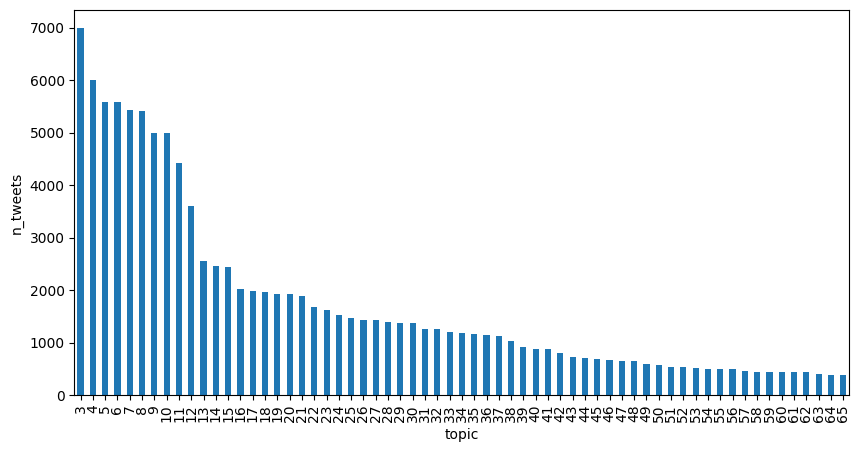

In [97]:
#keys as int
a = df_topics.reset_index()
a[a['topic'] > 1.0]['original'].plot(kind='bar', figsize=(10,5), xlabel='topic', ylabel='n_tweets')


In [111]:
g.vs.select(topics=23)['text']

['Supermarkets and food producers: what are you going to do about your plastic fetish in 2022? #COP26 #environment #plasticpollution #Recycle #reuse',
 "If we don't take action to stop the continous dumping of plastic in our country the results will be devastating &#10;#wedonthavetimeKe &#10;#COP26 &#10;@Patkiash &#10;@environpreneur &#10;@gideonwafula34 &#10;@SimiyuTitus01",
 'The latest GT Recycling - Recycling and Environmental news from all around the globe.! https://t.co/K3FNAOTJbu #cop26 #climateaction',
 'Fantastic to speak with @LawrieIP during #COP26 to find out what they are doing to reduce #carbonemissions: from employee engagement to waste disposal. &#10;https://t.co/QgFD8zSCOC',
 'The latest GT Recycling - Recycling and Environmental news from all around the globe.! https://t.co/keW6df95Lw #cop26 #climateaction',
 'Trails of litter&#10;#COP26 On one hand, the CDA has shown its inability to stop illegal constructions; on the other hand, unelected and incompetent people are 

# multinet

In [17]:
import uunet.multinet as ml
projected_path = folder + 'networks/cop26_retweets_ml.gml'

mln = ml.read(projected_path)


In [18]:
ml_summary = ml.summary(mln)

In [121]:
pd.DataFrame.from_dict(ml_summary).sort_values('n', ascending=False).head(50)

,layer,n,m,dir,nc,slc,dens,cc,apl,dia
54,-1.0,274242,724244,True,263354,9132,0.000010,0.021508,6.779334,23
20,0.0,162719,400793,True,157134,4142,0.000015,0.024580,6.910612,23
9,1.0,70793,153127,True,69800,391,0.000031,0.054078,7.257007,19
14,8.0,32759,62077,True,32469,181,0.000058,0.060259,5.601228,18
2,16.0,31933,57236,True,31917,4,0.000056,0.039110,1.500000,2
13,2.0,26519,43146,True,26116,16,0.000061,0.064580,3.408333,8
50,6.0,23428,40464,True,23142,79,0.000074,0.079547,5.291788,12
62,5.0,22469,48413,True,21972,70,0.000096,0.061238,6.410559,16
38,10.0,19401,31805,True,19217,78,0.000085,0.067529,4.859973,13
64,11.0,18512,32161,True,18346,18,0.000094,0.069425,3.532680,8


In [79]:
deg = ml.degree(mln)
act = ml.actors(mln)

degrees = [ [deg[i], act[i]] for i in range(len(deg)) ]
degrees.sort(reverse = True) 

top_actors = []
for el in degrees[0:10]: 
      top_actors.append(el[1])

layer_deg = dict()
layer_deg["actor"] = top_actors
for layer in ml.layers(mln):
    layer_deg[layer] = ml.degree(mln, actors = top_actors, layers = [layer] )
    
pd.DataFrame.from_dict(layer_deg)

,actor,72.0,14.0,55.0,37.0,13.0,93.0,53.0,3.0,69.0,...,66.0,58.0,4.0,74.0,1.0,70.0,68.0,54.0,87.0,94.0
0,UNFCCC,2.0,321.0,30.0,2.0,NaN,64.0,1.0,432.0,277.0,...,NaN,133.0,839.0,18.0,755.0,NaN,NaN,183.0,52.0,NaN
1,UN,1.0,329.0,NaN,3.0,4.0,NaN,NaN,18.0,1.0,...,3.0,1.0,326.0,NaN,458.0,NaN,NaN,1.0,51.0,NaN
2,COP22,76.0,127.0,4.0,NaN,NaN,2.0,6.0,152.0,NaN,...,7.0,13.0,154.0,1.0,213.0,NaN,4.0,NaN,NaN,NaN
3,UNDP,NaN,17.0,NaN,NaN,43.0,15.0,NaN,1154.0,1.0,...,133.0,NaN,931.0,NaN,228.0,NaN,NaN,NaN,NaN,NaN
4,pablorodas,8.0,97.0,11.0,478.0,351.0,NaN,NaN,86.0,NaN,...,47.0,17.0,19.0,2.0,21.0,324.0,NaN,3.0,3.0,NaN
5,UNICEF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,UNEP,NaN,3.0,33.0,NaN,NaN,NaN,NaN,NaN,12.0,...,302.0,1.0,79.0,24.0,234.0,NaN,NaN,NaN,1.0,NaN
7,WorldBank,NaN,20.0,113.0,NaN,NaN,6.0,NaN,278.0,1.0,...,NaN,3.0,2.0,NaN,374.0,NaN,NaN,NaN,NaN,NaN
8,LeoDiCaprio,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2922.0,NaN,NaN,1.0,NaN,NaN
9,sustainable_4rt,NaN,18.0,13.0,NaN,22.0,NaN,2.0,115.0,8.0,...,15.0,14.0,85.0,10.0,180.0,NaN,NaN,9.0,NaN,NaN


In [122]:
# user with most retweets
topic_label

{-1: 'Climate Crisis Action',
 0: 'Climate Change Action',
 1: 'COP26 Climate Pact',
 2: 'Carbon Emission Reduction',
 3: 'Aircraft Flight Tracking',
 4: 'Australian Climate Change and COP',
 5: 'Glasgow_COP26',
 6: 'Deforestation and Reversal by 2030',
 7: 'Food and Farming Systems',
 8: 'Fossil Fuel Lobbyists at Climate Talks',
 9: 'Renewable Energy Sources',
 10: 'Coal Phase-down in COP Decision',
 11: 'Global Warming Temperature Rise',
 12: 'African Climate Change',
 13: 'Gender Equality & Climate Change',
 14: 'China-Russia Climate Summit',
 15: 'Vaccination and Climate Change',
 16: 'Private Jet Emissions',
 17: "India's Net-Zero Carbon Emissions by 2070",
 18: 'Greenwashing & Credentials',
 19: 'Tory Corruption in UK',
 20: 'Climate Change, Faith, Prayer',
 21: 'Climate Finance for Developing Countries',
 22: 'Methane Emissions Reduction',
 23: 'Plastic Recycling Solutions',
 24: 'Indigenous Rights & Communities',
 25: 'Youth Climate Activism',
 26: 'Climate Change and COP Disco

In [123]:
df_original[df_original['topic'] == 5].sort_values('indegree', ascending=False).head(10)

,tweets,indegree,author,topic
87614,794266760744763392,374,UNFCCC,5.0
29690,798870486759407616,336,JohnKerry,5.0
81116,795611528997244928,265,UN,5.0
86994,794481733563482112,248,UNEP,5.0
85817,794641346267148288,245,UNFCCC,5.0
86801,794505196554620928,229,EU_Commission,5.0
12136,800155458300481536,182,nature_org,5.0
86614,794530920632090624,181,UNFCCC,5.0
96810,784107739819769859,173,ConservationOrg,5.0
83795,795324765095477248,148,EU_Commission,5.0


In [126]:
tweets['text']

['2,000-5000 liters of #water are needed to produce a person&#8217;s daily food #COP22&#160;&#8230; https://t.co/mdld9OjxXS https://t.co/vpWqHYytyI',
 '2,000-5000 liters of #water are needed to produce a person&#8217;s daily food #COP22&#160;&#8230; https://t.co/DrfrEuPMev https://t.co/28EYhLy4Ae',
 '2,000-5000 liters of #water are needed to produce a person&#8217;s daily food #COP22&#160;&#8230; https://t.co/YAs69AtLAE https://t.co/KVKamz5bCK',
 '#CLIMATEchange #p2 RT Top 10 HAPPY environmental stories of 2016. https://t.co/rbTENUUZI5 #COP22 #tcot #2A https://t.co/C4owMuusW5',
 '#CLIMATEchange #p2 RT Our best environment stories from this past&#160;year. https://t.co/f5lY9m4sE2 #COP22 #tcot #2A https://t.co/dFF8I5vESR',
 "My only wish for 2017: that Trump won't destroy the world. #p2 #Uniteblue #tcot #tlot #GOP #feelthebern #Obama #POTUS #climatechange #COP22",
 '#CLIMATEchange #p2 RT  How much fossil fuel has been used in your lifetime? https://t.co/3xOS9PxvHe #COP22 #tcot #2A https:

In [1]:
tweets

NameError: name 'tweets' is not defined

In [ ]:
a